## Golden Master Image Algorithm

# History of Changes:

    June 01, 2017    Benja          Creates Image Algorihtm Notebook in Python bsed on existing code in Android App
    June 10, 2017    Banja+Demian   Documentation changes (e.g. the term XM Markes to indicate indivual tests)
    June 20, 2017    Demian         Added Batch + Crop and Save functionality for saving XM-Markers to db or file  


## Script Input Parameters:

        batch == True    Sends output or results to disk or db
        batch == False   Standard output on Jupyter Notebook (for Interactive Validation of Images Analysis)

In [31]:
import numpy as np
import cv2
import operator
from matplotlib import pyplot as plt
import sys 

#Scripts para leer y procesar imagen
sys.path.insert(0, '../Golden Master (AS IS)')
import readImage
import preProcessing as pP
import sorts as srt
import perspective as pPe
import indAnalysis as inA
import writeImage2

In [32]:
batch = False
qr = '601170500100157'
qr_count = 1

### Read Image

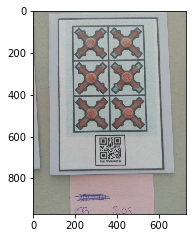

In [33]:
#Read from local file local = True, from db local = False, count = Test repeated
imgRGB = readImage.readImage(qr, local = False, count = qr_count)
if(isinstance(imgRGB, str)):
    print(imgRGB)
else: 
    # show the original image
    if (not batch):
     plt.subplot(121),plt.imshow(imgRGB)
     plt.show()

### Find Border of Biggest Square

Length:  7 type: <type 'list'>
(970L, 728L, 3L)


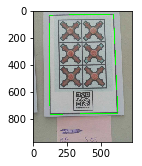

In [34]:
if(isinstance(imgRGB, str)):
    print(imgRGB)
else: 
    imgResized = pP.resizeImg(imgRGB, 728)
    imgBinary = pP.contourBinarization(imgRGB, 3, 7, 85, 2, inverse = True, mean = False)
externalSquare = pP.findTreeContours(imgBinary)
rgbCopy = imgRGB.copy()
cv2.drawContours(rgbCopy, [externalSquare[1]], -1, (0, 255, 0), 3)

#show contour image
# show resized and binary images
if (not batch):
    print("Length:  " + str(len(externalSquare)) + " type: " + str(type(externalSquare)))
    print(imgRGB.shape)
    plt.subplot(131),plt.imshow(rgbCopy)
    #plt.subplot(132),plt.imshow(imgResized)
    #plt.subplot(133),plt.imshow(imgBinary, 'gray')
    plt.show()

### Validate Perspective for Biggest Square

[array([[77, 13]]), array([[633,   4]]), array([[ 84, 784]]), array([[672, 769]])]


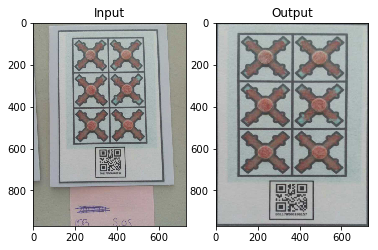

In [35]:
#Order points to identify region of interest
#printPoints(externalSquare)
externalOrdSquare = srt.sortPointsContours(externalSquare)
imgValidated = pPe.perspectiveTransform(imgRGB, externalOrdSquare[1], 0)

if(not batch):
    print(externalOrdSquare[0])
    plt.subplot(121),plt.imshow(imgRGB),plt.title('Input')
    plt.subplot(122),plt.imshow(imgValidated),
    plt.title('Output')
    plt.show()

### Validate Perspective for "Test Square" 

2


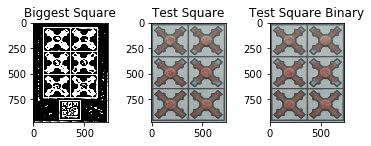

In [36]:
#Test Square lives inside Biggest Square and holds individual test's squares (a.k.a. X-Markers and XM Group)
#Do the actual perspective transform (previous one was for validating test device is there, and all margins align)
perspectiveBinary = pPe.perspectiveTransform(imgBinary, externalOrdSquare[1], -5, True)
perspectiveRGB = pPe.perspectiveTransform(imgRGB, externalOrdSquare[1], -5)
external = pP.findExternalContours(
    perspectiveBinary)
testSquareBinary = pPe.getTestSquare(perspectiveBinary, external, True)  
testSquareRGB = pPe.getTestSquare(perspectiveRGB, external)  
if (not batch):
    print(len(external))
    plt.subplot(231),plt.imshow(perspectiveBinary, 'gray'),plt.title('Biggest Square')
    plt.subplot(232),plt.imshow(testSquareRGB),plt.title('Test Square')
    plt.subplot(233),plt.imshow(testSquareRGB, 'gray'),plt.title('Test Square Binary')
    plt.show()

### Validate Individual Tests (a.k.a. X-M Markers)

Approx ind area: 88260
Number of X-Markers found: 6


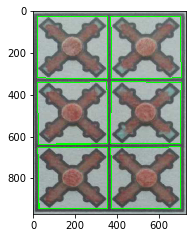

In [37]:
testSquareRGBCopy = testSquareRGB.copy()
height, width = testSquareRGB.shape[:2]
areaInd = (height*width/8) - 10
#Binarization is required again because lost of details on first binarization
contoursInd = pP.findTreeContours(pP.contourBinarization(testSquareRGB, 3, 7, 85, 2),areaInd)
if(len(contoursInd) == 7 ): 
    contoursInd = contoursInd[1:]
for c in contoursInd:
    cv2.drawContours(testSquareRGBCopy, [c], -1, (0, 255, 0), 3)

if (not batch):  
    print("Approx ind area: " + str(areaInd))
    print("Number of X-Markers found: " + str(len(contoursInd)))
#Draw contour for ind tests (a.k.a. X-Markers)
    plt.subplot(121),plt.imshow(testSquareRGBCopy)
    plt.show()

### Crop Individual Test's Images (a.k.a. X-M Markers)

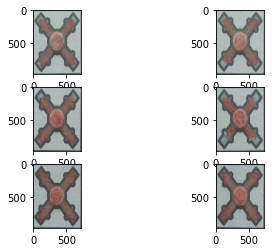

(970L, 728L, 3L)


In [38]:
srt.sortTests(contoursInd)
listTests = []
if(len(contoursInd) == 6):
    for i,c in enumerate(contoursInd):
        test = pPe.getIndTest(testSquareRGB,c)
        listTests.append(test)         
    if (not batch):
        for i,test in enumerate(listTests):
            plt.subplot(321 + i),plt.imshow(test)
        plt.show()
        print(test.shape)
    else:
        for i,test in enumerate(listTests):
            xm_id = str(qr) + "_" + str(qr_count).zfill(3) + "_" + str(i).zfill(2)
            ext = ".png"
            status_write = writeImage2.writeLocal(xm_id + ext, test)
            print("Saving XM-Marker to local folder : " + xm_id + ", Status = " + str(status_write))

### X-Marker Analysis (a.k.a. Sitios de prueba)

(90L, 90L)


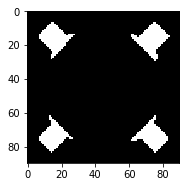

In [39]:
mask = inA.readMask()
ret, mask = cv2.threshold(pP.BGR2gray(mask),127,255,cv2.THRESH_BINARY)
if (not batch):
    print(mask.shape)
    plt.subplot(121),plt.imshow(mask, 'gray')
    plt.show()

X-Markers: resized


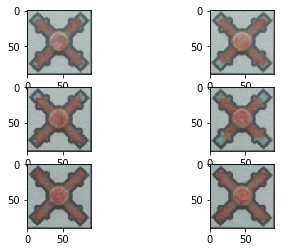

X-Markers: Binary


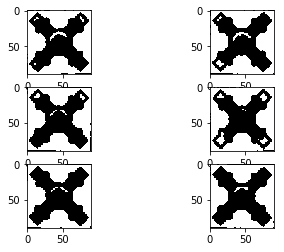

X-Markers: Binary + Mask Applied


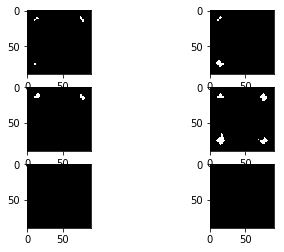

X-Markers: Blobs


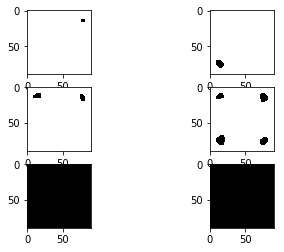

In [48]:
#Fixed size 90x90
listTestsResized = inA.resizeAll(listTests)
listTestsBinary = []
listTestsBinaryMask = []
listTestsBinaryMaskEroDil = []

#resized RGB
if (not batch):
    for i, test in enumerate(listTestsResized):
        if (not batch):
          plt.subplot(321 + i),plt.imshow(test)
    if (not batch):
      print("X-Markers: resized")
      plt.show()

#X-Markers resized binary
for i, test in enumerate(listTestsResized):
    testBin = pP.contourBinarization(test, 3, 3, 105, 4, inverse = False, mean = True)
    listTestsBinary.append(testBin)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(testBin, 'gray')
if (not batch):
    print("X-Markers: Binary")
    plt.show()

#X-Markers binary with mask
for i, test in enumerate(listTestsBinary):
    testBinMask = inA.andOperation(test, mask)
    listTestsBinaryMask.append(testBinMask)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(testBinMask, 'gray')
if(not batch):
    print("X-Markers: Binary + Mask Applied")
    plt.show()

# erode and dilate blobs
for i, test in enumerate(listTestsBinaryMask):
    test = inA.erosionDilation(test, 3)
    test = cv2.bitwise_not(test)
    listTestsBinaryMaskEroDil.append(test)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(test, 'gray')
if (not batch):
    print("X-Markers: Blobs")
    plt.show()

Blobs detected: 1 Blobs detected: 1
Blobs detected: 2 Blobs detected: 4
Blobs detected: 0 Blobs detected: 0


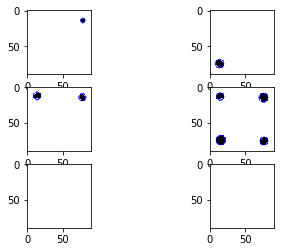

Result: N Area: 6.32455539703 Result: N Area: 12.1655254364
Result: I Area: 20.5053796768 Result: P Area: 48.2304840088
Result: N Area: 0 Result: N Area: 0


In [46]:
#Blob detection
listBlobs = []
for i,img in enumerate(listTestsBinaryMaskEroDil):
    imgCopy = img.copy()
    blobs = inA.blobDetect(img)
    listBlobs.append(blobs)
    if(not batch):
        if(operator.mod(i,2) != 0): #Print two by line
            print("Blobs detected: " + str(len(listBlobs[i-1])) + 
              " Blobs detected: " + str(len(listBlobs[i])))
        plt.subplot(321 + i),plt.imshow(inA.drawBlobs(imgCopy, blobs), 'gray')
if(not batch):
  plt.show()

#Test results using blobs
for i, img in enumerate(listTestsBinary):
    if(operator.mod(i,2) != 0): #Print two by line
        if(not batch):
            print("Result: " + inA.blobAnalysis(img, listBlobs[i-1]) + 
              " Area: " + str(inA.areaEstimation(listBlobs[i-1])) +
              " Result: " + inA.blobAnalysis(img, listBlobs[i]) +
             " Area: " + str(inA.areaEstimation(listBlobs[i])))

X-Markers: resized


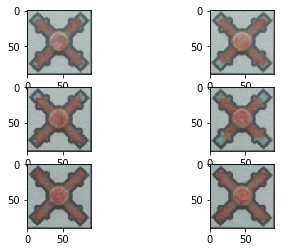

X-Markers: Resized + Mask Applied


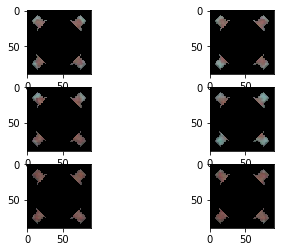

In [52]:
#resized RGB
if (not batch):
    for i, test in enumerate(listTestsResized):
        if (not batch):
          plt.subplot(321 + i),plt.imshow(test)
    if (not batch):
      print("X-Markers: resized")
      plt.show()


#X-Markers with mask
listTestsResizedMask = []
for i, test in enumerate(listTestsResized):
    testResMask = inA.andOperation(test, mask)
    listTestsResizedMask.append(testResMask)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(testResMask, 'gray')
if(not batch):
    print("X-Markers: Resized + Mask Applied")
    plt.show()
